# 3. Polarity Analysis

**Polarity analysis** is a specific type of *sentiment analysis* that focuses on determining whether the sentiment expressed in the text is positive, negative, or neutral, assigning a polarity score that usually ranges from -1 to 1. In particular:

* ***Positive*** *Polarity:* if the polarity score is close to **1**, indicating a *positive* sentiment. 

* ***Negative*** *Polarity:* if the polarity score is close to **-1**, revealing a *negative* sentiment. 

* ***Neutral*** *Polarity:* if the polarity score is close to **0**, representing a *neutral* sentiment. 

Polarity analysis is widely used in various applications, including social media monitoring, customer *feedback* analysis, brand *reputation* management, product *reviews* analysis, and more. It helps organizations gain insights into the overall sentiment of their customers or the public regarding their products, services, or brands.

Since it can be performed using various techniques, including *rule-based* methods, *machine learning-based* methods, and *pre-trained* models, let's analyse two of the most common approaches: **VADER** Sentiment Scoring and **ROBERTA** Pre-Trained Model. 

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import classification_report

In [2]:
# Read in Clean Data
df = pd.read_csv('rws_eda.csv')
df.rename(columns = {'Unnamed: 0': 'Id'}, inplace = True)
df.head(1)

,Id,Clean Title,Clean Content,Rating,Sentiment,Target
0,0,second time buying headphones overall value money,lost first pair replaced really like fit sound...,4,Positive,2


## 3.1. VADER Sentiment Scoring

**VADER** (Valence Aware Dictionary and sEntiment Reasoner) is a **lexicon** and **rule-based** sentiment analysis tool specifically designed for assessing the sentiment of social media text like tweets, online reviews and comments, *without* requiring for previous training. 

In particular, VADER uses a **pre-built** lexicon (a dictionary) of *words* and their sentiment *scores*: the lexicon includes words with their *polarity* (positive or negative sentiment) and *intensity* scores. Another important feature of the tool is the **valence score**: VADER calculates a *valence* score for each input text, representing the *overall* sentiment polarity (positive, neutral, or negative) and intensity. 

The result generated by the tool is a *dictionary* of four keys: 
* **neg**, **neu**, and **pos** represent the proportions of the text expressing respectively *negative*, *neutral*, and *positive* sentiment. 
* **compound** score is an *overall* sentiment score, ranging from **-1** (extremely negative) to **+1** (extremely positive).
Their sum should be equal to 1 or close to it with float operation. Using the *compound* score can be enough to determine the underlying *sentiment* of a text, because for:
    * a *positive* sentiment, compound **≥** 0.05 
    * a *negative* sentiment, compound **≤** -0.05 
    * a *neutral* sentiment, the compound is **between** (-0.05, 0.05).

In [3]:
# VADER dataframe
dfv = df
print(dfv.shape)

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

(100, 6)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\debby\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Example text for sentiment analysis
text = 'I love this product. It is amazing!'

# Get sentiment scores using VADER
vader_results = sia.polarity_scores(text)

# Print the sentiment scores
print(vader_results)

{'neg': 0.0, 'neu': 0.325, 'pos': 0.675, 'compound': 0.8516}


In this example, the compound score is 0.8516, indicating a positive sentiment.

Let's run the **sia.polarity_scores()** method over the entire DataFrame (dfv). 

The following code iterates over each row in the *' dfv '* using the **iterrows()** procedure, while the **tqdm()** function provides a bar to track the progress of the loop. The calculated sentiment scores are stored in a *dictionary* named **res_clean**, where the key is the *' Id '* column value from the DataFrame, and the value is the sentiment scores for the corresponding *'Clean Content'* column value:

In [5]:
# Run the Polarity Score on the CLEAN Content 
res_clean = {}
for i, row in tqdm(dfv.iterrows(), total = len(dfv)):
    text = row['Clean Content']
    Id = row['Id']
    # Store the polarity score of the text
    res_clean[Id] = sia.polarity_scores(text)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
# Store the dictionary into a DataFrame
vader_clean = pd.DataFrame(res_clean).T
# Reset the index and rename columns to merge 'vader_clean' with 'dfv'
vader_clean = vader_clean.reset_index().rename(columns = {'index': 'Id', 
                                             'neg': 'Vader Neg', 
                                             'neu':'Vader Neu',
                                             'pos':'Vader Pos',
                                             'compound':'Vader Compound'})     
vader_clean = vader_clean.merge(dfv, how = 'left')
# Senitment Categories are now the Index of the transposed DataFrame
vader_clean.head(1)

,Id,Vader Neg,Vader Neu,Vader Pos,Vader Compound,Clean Title,Clean Content,Rating,Sentiment,Target
0,0,0.087,0.606,0.308,0.9147,second time buying headphones overall value money,lost first pair replaced really like fit sound...,4,Positive,2


To reflect the sentiment of the reviews for products within each star rating category, let's plot VADER results: each bar will indicate the ***average*** *compound* sentiment score for each unique *'Rating'* category (Amazon star rating) present in the DataFrame:

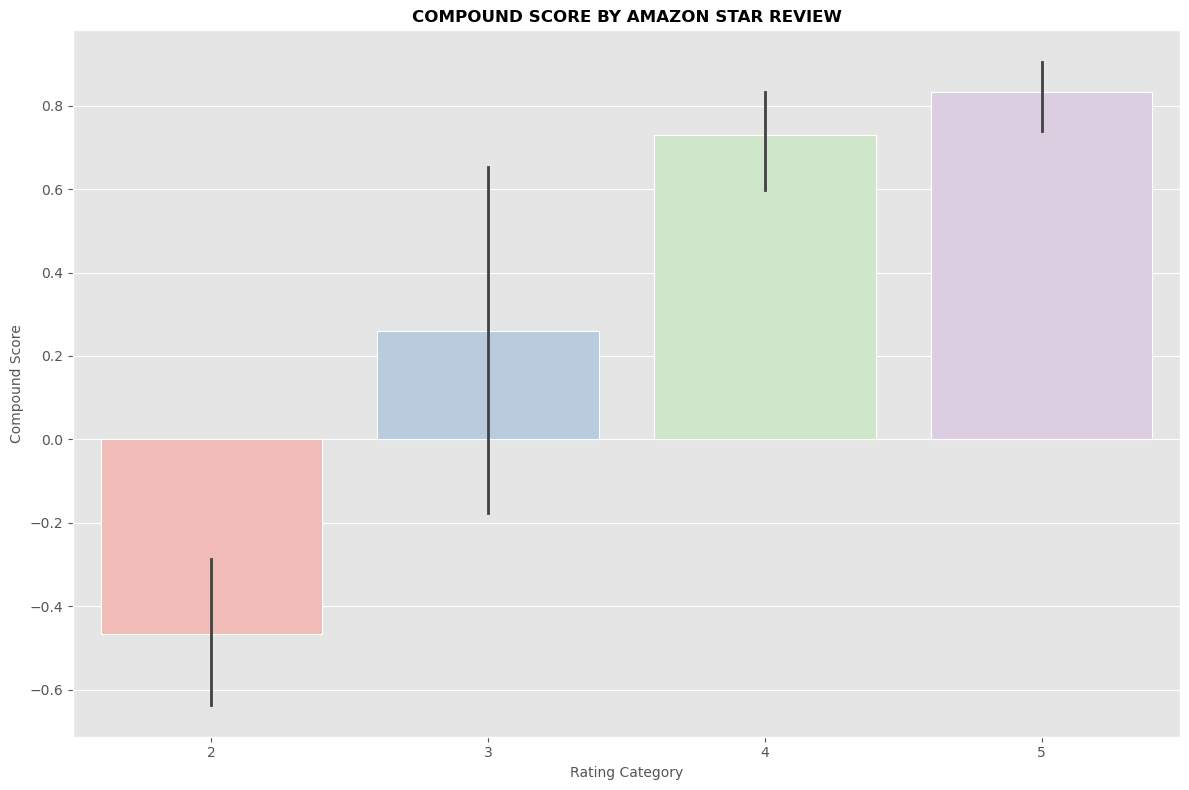

In [7]:
plt.figure(figsize = (12, 8))

# VADER Results
sns.barplot(data = vader_clean, x = 'Rating', y = 'Vader Compound', palette = 'Pastel1', errwidth = 2, linewidth = 0.8, edgecolor = 'white')
plt.title('COMPOUND SCORE BY AMAZON STAR REVIEW', fontweight = 'bold', fontsize = 12)
plt.xlabel('Rating Category', fontsize = 10)
plt.ylabel('Compound Score', fontsize = 10)

plt.tight_layout()
plt.show()

In [8]:
count_rating_1 = vader_clean['Rating'].value_counts().get(1, 0)
print("Number of rows with Rating 1:", count_rating_1)

Number of rows with Rating 1: 0


As expected, the violet bar is *taller* towards the ***positive*** end of the y-axis (closer to +1) meaning that products with *5 star* rating generally have more positive sentiments associated with them. On the other hand, the pink bar is *taller* towards the ***negative*** end of the y-axis (closer to -1) revealing that products with *1/2 stars* rating generally have more negative sentiments associated with them.

Let's visualize the ***distribution*** of sentiment scores (positive, neutral, and negative) based on different Amazon *star reviews*:

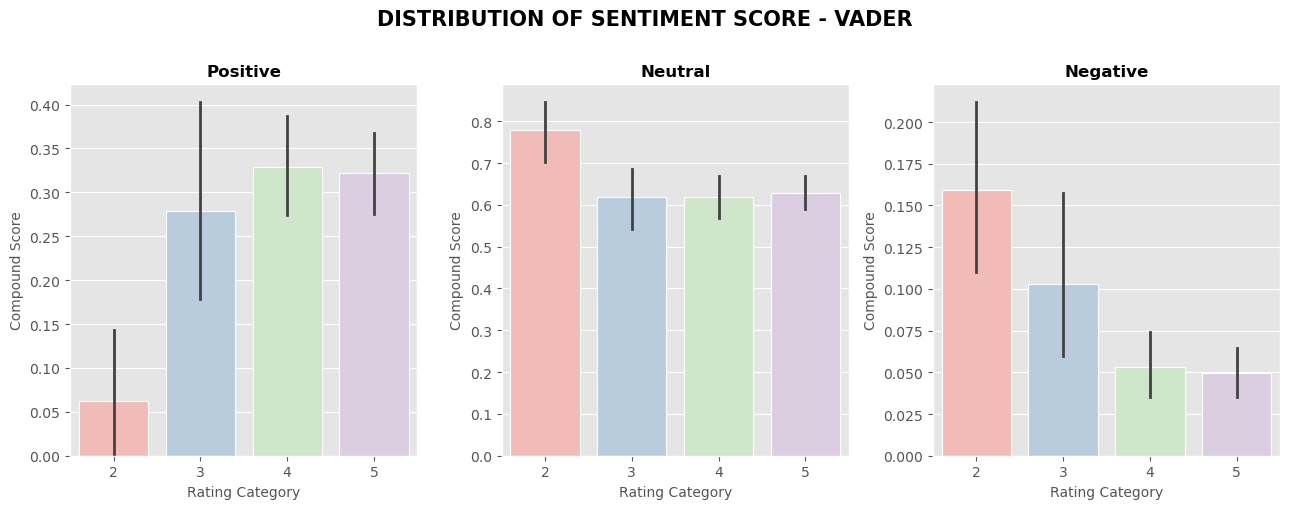

In [9]:
# VADER - CLEAN
fig, axs = plt.subplots(1, 3, figsize = (13, 5))

# Positive Sentiment
sns.barplot(data = vader_clean, x = 'Rating', y = 'Vader Pos', ax = axs[0], palette = 'Pastel1', errwidth = 2, linewidth = 0.8, edgecolor = 'white')
axs[0].set_title('Positive', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Rating Category', fontsize = 10)
axs[0].set_ylabel('Compound Score', fontsize = 10)

# Neutral Sentiment
sns.barplot(data = vader_clean, x = 'Rating', y = 'Vader Neu', ax = axs[1], palette = 'Pastel1', errwidth = 2, linewidth = 0.8, edgecolor = 'white')
axs[1].set_title('Neutral', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Rating Category', fontsize = 10)
axs[1].set_ylabel('Compound Score', fontsize = 10)

# Negative Sentiment
sns.barplot(data = vader_clean, x = 'Rating', y = 'Vader Neg', ax = axs[2], palette = 'Pastel1', errwidth = 2, linewidth = 0.8, edgecolor = 'white')
axs[2].set_title('Negative', fontweight = 'bold', fontsize = 12)
axs[2].set_xlabel('Rating Category', fontsize = 10)
axs[2].set_ylabel('Compound Score', fontsize = 10)

plt.suptitle('DISTRIBUTION OF SENTIMENT SCORE - VADER', fontweight = 'bold', fontsize = 15, y = 1.01)
plt.tight_layout()
plt.show()

Inspecting the barplots, we can confirm the *relationship* between the compound score and the different star ratings given by customers to products on Amazon.

Although VADER offers the advantage of being a *quick* and *rule-based* sentiment analysis tool, its **limitations** could potentially have a *negative* impact on the sentiment analysis.

For instance, when dealing with complex or nuanced language such as product reviews from Amazon, irony and sarcasm could be misinterpreted, misspelt or get grammatical errors in the text: VADER treats each word independently (*contextual ambiguity*), which can lead to *inaccurate* sentiment analysis for sentences with composite structures. In addition, VADER's lexicon is based on human judgments and may reflect the *biases* of its creators (*subjectivity*). 

Since VADER is **not** a machine learning model and does not learn from data, it can**not** be adapted for specific domains and it could **not** be as accurate as other models that use machine learning techniques. 

Let's introduce a more accurate sentiment analysis tool: **ROBERTA Pre-trained Model**.

## 3.2. ROBERTA Pre-trained Model

**ROBERTA** (A Robustly Optimized BERT Pretraining Approach) is a state-of-the-art **pre-trained** language model based on the *transformer* architecture and developed by Facebook AI Research (FAIR). It builds upon the success of the *BERT* (Bidirectional Encoder Representations from Transformers) model and is available through the Hugging Face Transformers library, which provides easy-to-use interfaces for using pre-trained language models. 

In particular, ROBERTA is trained on a *massive* amount of data (**Large-Scale** training) to capture more diverse language patterns rather than VADER, and uses a *bidirectional* approach to learn contextual embeddings (**Bidirectional** training) looking at both the left and the right contexts of a word in the sentence. Due to the *large* model size and the *extensive* training data, the pre-training tool requires **huge** computational *resources* and *time* to perform on various natural language processing (NLP) tasks, including sentiment analysis, text classification, named entity recognition, and machine translation.

The result generated by the tool is a dictionary with three keys: **Roberta neg**, **Roberta neu**, and **Roberta pos**, each corresponding respectively to the sentiment scores for *negative*, *neutral*, and *positive* sentiment.

In [10]:
# Read in data
dfr = df         
print(dfr.shape)

(100, 6)


It is necessary to define the **pre-trained** model to be used for sentiment analysis, named *' cardiffnlp/twitter-roberta-base-sentiment '*:

In [11]:
# Specific Pre-Trained Model
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
# Tokenization: convert input text into numerical representations suitable for the model
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# Model Initialization
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [12]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors = 'pt')     # Tokenizer: convert input text into numerical representations            
    output = model(**encoded_text)                            # Output: we are interested in the first output
    scores = output[0][0].detach().numpy()                    # Softmax Probability: raw scores represent the sentiment scores for each class
    scores = softmax(scores)                                  # Normalize Scores and Convert them into probabilities
    scores_dict = {
        'Roberta Neg' : scores[0],
        'Roberta Neu' : scores[1],
        'Roberta Pos' : scores[2]
    }
    return scores_dict

The ****** symbol is used to denote a *dictionary* of keyword arguments. This allows a function to accept any number of named arguments, including zero.

In [13]:
# Example text for sentiment analysis
text = 'I love this product. It is amazing!'

# Get sentiment scores using ROBERTA
roberta_results = polarity_scores_roberta(text)

# Print the sentiment scores
print(roberta_results)

{'Roberta Neg': 0.0021455686, 'Roberta Neu': 0.005187055, 'Roberta Pos': 0.9926674}


ROBERTA Pre-Trained Model confirms the results provided by VADER tool, indicating a *positive* sentiment but with different *scores* (0.993 and 0.675 rispectively).

Let's run the **polarity_scores_roberta()** function over the entire DataFrame (dfr). 

The following code iterates over each row in the *' dfr '* using the **iterrows()** procedure, while the **tqdm()** function provides a bar to track the progress of the loop. The calculated sentiment scores are stored in a *dictionary* named **res_clean**, where the key is the *' Id '* column value from the DataFrame, and the value is the sentiment scores for the corresponding *' Clean Content '* column value:

In [14]:
# Run the polarity score on the ENTIRE dataset 
res_clean = {}
for i, row in tqdm(dfr.iterrows(), total = len(dfr)):
    try:
        text = row['Clean Content']
        Id = row['Id']
        # Store the polarity score of the text
        res_clean[Id] = polarity_scores_roberta(text) 
    except RuntimeError:
        print(f'Broke for id {Id}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
# Store the dictionary into a DataFrame
roberta_clean = pd.DataFrame(res_clean).T
# Reset the index and rename columns to merge 'roberta_clean' with 'dfr'
roberta_clean = roberta_clean.reset_index().rename(columns = {'index': 'Id'})

roberta_clean = roberta_clean.merge(dfr, how = 'left')
# Senitment Categories are now the Index of the transposed DataFrame
roberta_clean.head(1)

,Id,Roberta Neg,Roberta Neu,Roberta Pos,Clean Title,Clean Content,Rating,Sentiment,Target
0,0,0.06986,0.281101,0.649038,second time buying headphones overall value money,lost first pair replaced really like fit sound...,4,Positive,2


Let's visualize the ***distribution*** of sentiment scores (positive, neutral, and negative) based on different Amazon *star reviews*:

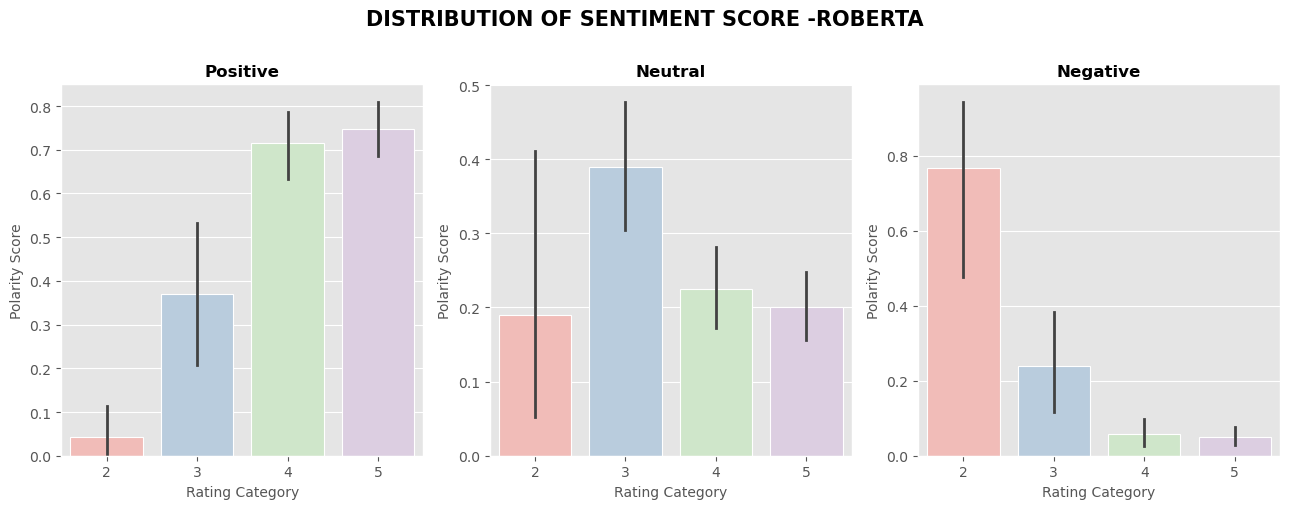

In [16]:
# Distribution of Sentiment Scores - CLEAN
fig, axs = plt.subplots(1, 3, figsize = (13, 5))

# Positive Sentiment
sns.barplot(data = roberta_clean, x = 'Rating', y = 'Roberta Pos', ax = axs[0], palette = 'Pastel1', errwidth = 2, linewidth = 0.8, edgecolor = 'white')
axs[0].set_title('Positive', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Rating Category', fontsize = 10)
axs[0].set_ylabel('Polarity Score', fontsize = 10)

# Neutral Sentiment
sns.barplot(data = roberta_clean, x = 'Rating', y = 'Roberta Neu', ax = axs[1], palette = 'Pastel1', errwidth = 2, linewidth = 0.8, edgecolor = 'white')
axs[1].set_title('Neutral', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Rating Category', fontsize = 10)
axs[1].set_ylabel('Polarity Score', fontsize = 10)

# Negative Sentiment
sns.barplot(data = roberta_clean, x = 'Rating', y = 'Roberta Neg', ax = axs[2], palette = 'Pastel1', errwidth = 2, linewidth = 0.8, edgecolor = 'white')
axs[2].set_title('Negative', fontweight = 'bold', fontsize = 12)
axs[2].set_xlabel('Rating Category', fontsize = 10)
axs[2].set_ylabel('Polarity Score', fontsize = 10)

plt.suptitle('DISTRIBUTION OF SENTIMENT SCORE -ROBERTA', fontweight = 'bold', fontsize = 15, y = 1.01)
plt.tight_layout()
plt.show()

Inspecting the barplots, we can confirm the *relationship* between the compound score and the different star ratings given by customers to products on Amazon.

## 3.3. Combine and Compare the Models

Let's combine the polarity scores obtained from the previous sentiment analysis methods on the entire dataset. The results are integrated into a new dictionary named **res_comb**, where each entry contains the *combined* sentiment scores for a specific text (identified by the *' Id '* ):

In [17]:
# Combine the Polarity Score on the ENTIRE dataset
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Clean Content']
        Id = row['Id']
        
        # Get sentiment scores using VADER
        vader_result = sia.polarity_scores(text)
        # Rename the keys in the dictionary to include the 'Vader' prefix
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'Vader {key}'] = value
            
        # Get sentiment scores using ROBERTA
        roberta_result = polarity_scores_roberta(text)
        
        # Combine the VADER and ROBERTA results into a single dictionary 'both'
        both = {**vader_result_rename, **roberta_result}   
        # Store the combined sentiment score
        results[Id] = both                               
        
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# Store the dictionary into a DataFrame
results_df = pd.DataFrame(results).T
# Reset the index and rename columns to merge 'results_df' with 'df'
results_df = results_df.reset_index().rename(columns = {'index': 'Id', 
                                             'Vader neg': 'Vader Neg', 
                                             'Vader neu':'Vader Neu',
                                             'Vader pos':'Vader Pos',
                                             'Vader compound':'Vader Compound'})
results_df = results_df.merge(df, how = 'left')
# Senitment Categories are now the Index of the transposed DataFrame
results_df.head(1)

,Id,Vader Neg,Vader Neu,Vader Pos,Vader Compound,Roberta Neg,Roberta Neu,Roberta Pos,Clean Title,Clean Content,Rating,Sentiment,Target
0,0,0.087,0.606,0.308,0.9147,0.06986,0.281101,0.649038,second time buying headphones overall value money,lost first pair replaced really like fit sound...,4,Positive,2


Let's compare the VADER and ROBERTA **labels** to see if there are any differences in sentiment classification:

In [19]:
# Store the Sentiment Labels in two new columns
results_df['Vader Label'] = results_df['Vader Compound'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))
results_df['Roberta Label'] = results_df['Roberta Pos'].apply(lambda x: 'Positive' if x >= 0.5 else ('Negative' if x <= 0.3 else 'Neutral'))

# Generate a Report creating two DataFrame
matching_sentiments = results_df[results_df['Vader Label'] == results_df['Roberta Label']]
disagree_sentiments = results_df[results_df['Vader Label'] != results_df['Roberta Label']]

total_reviews = len(results_df)
# Percentage of matching and disagreeing sentiments
matching_percentage = len(matching_sentiments) / total_reviews * 100
disagree_percentage = len(disagree_sentiments) / total_reviews * 100

print(f'Percentage of reviews with matching sentiments: {matching_percentage:.2f}%')
print(f'Percentage of reviews where VADER and ROBERTA disagree: {disagree_percentage:.2f}%')

Percentage of reviews with matching sentiments: 84.00%
Percentage of reviews where VADER and ROBERTA disagree: 16.00%


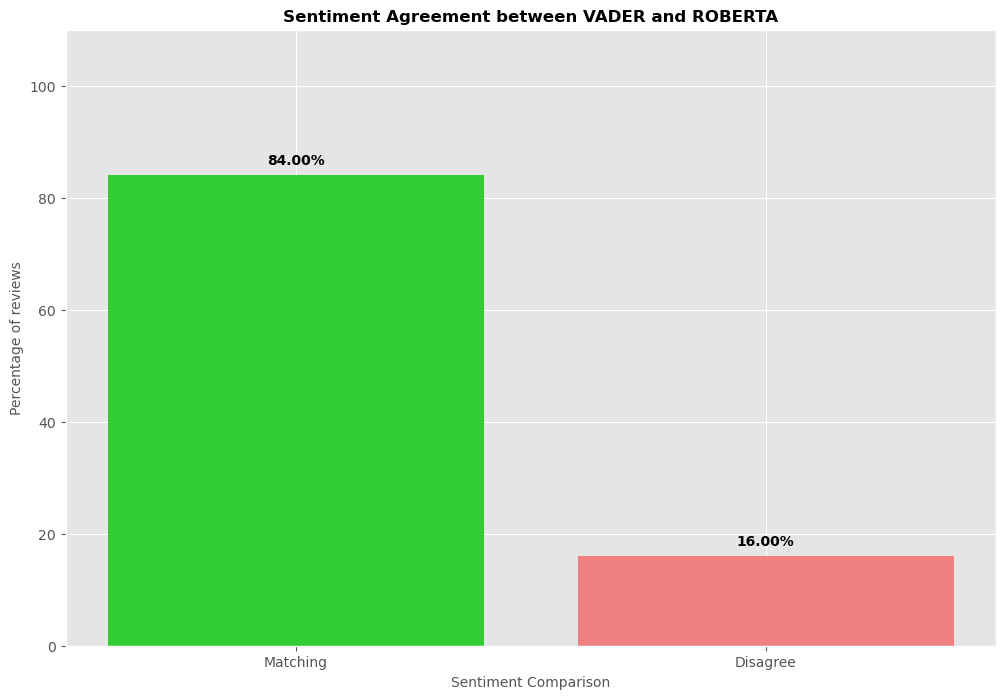

In [20]:
sentiment_data = [matching_percentage, disagree_percentage]
labels = ['Matching', 'Disagree']

# Sentiment Agreement (%)
plt.figure(figsize = (12, 8))
plt.bar(labels, sentiment_data, color = ['limegreen', 'lightcoral'])
plt.title('Sentiment Agreement between VADER and ROBERTA', fontweight = 'bold', fontsize = 12)
plt.xlabel('Sentiment Comparison', fontsize = 10)
plt.ylabel('Percentage of reviews', fontsize = 10)
plt.ylim(0, 110) 

# Display the percentages on the bars
for i, v in enumerate(sentiment_data):
    plt.text(i, v + 2, f'{v:.2f}%', ha = 'center', color = 'black', fontweight = 'bold')

plt.show()

Let's show VADER and ROBERTA sentiment distributions:

In [21]:
# Calculate counts of sentiment labels for VADER
vader_counts = results_df['Vader Label'].value_counts()

# Calculate counts of sentiment labels for ROBERTA
roberta_counts = results_df['Roberta Label'].value_counts()

# Get labels and sizes for VADER
vader_labels = vader_counts.index
vader_sizes = vader_counts.values

# Get labels and sizes for ROBERTA
roberta_labels = roberta_counts.index
roberta_sizes = roberta_counts.values

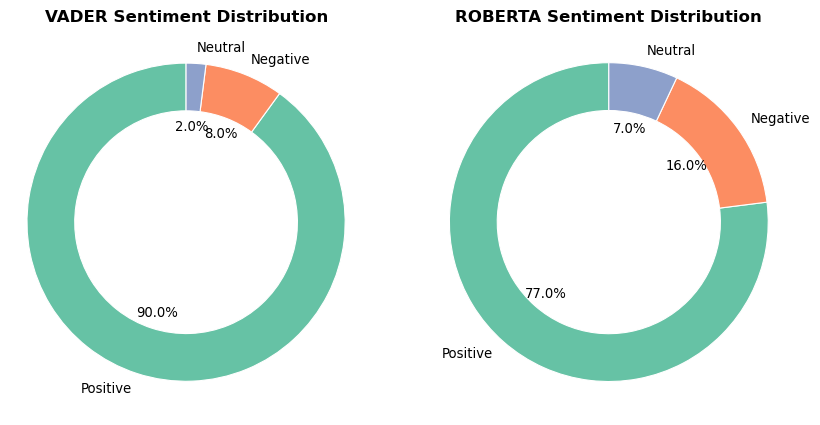

In [22]:
# Sentiment Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
colors = sns.color_palette('Set2')[0:3]

ax1.pie(vader_sizes, labels = vader_labels, autopct = '%1.1f%%', startangle = 90, textprops = {'fontsize':9.5}, colors = colors, wedgeprops = {'width' : 0.3, 'linewidth' : 0.8, 'edgecolor' : 'white'})
ax1.set_title('VADER Sentiment Distribution', fontweight = 'bold', fontsize = 12)
ax1.axis('equal')
ax2.pie(roberta_sizes, labels = roberta_labels, autopct = '%1.1f%%', startangle = 90, textprops = {'fontsize':9.5}, colors = colors, wedgeprops = {'width' : 0.3, 'linewidth' : 0.8, 'edgecolor' : 'white'})
ax2.set_title('ROBERTA Sentiment Distribution', fontweight = 'bold', fontsize = 12)
ax2.axis('equal')
plt.show()

Let's compare the **ratings** between the models by Amazon Star Review:

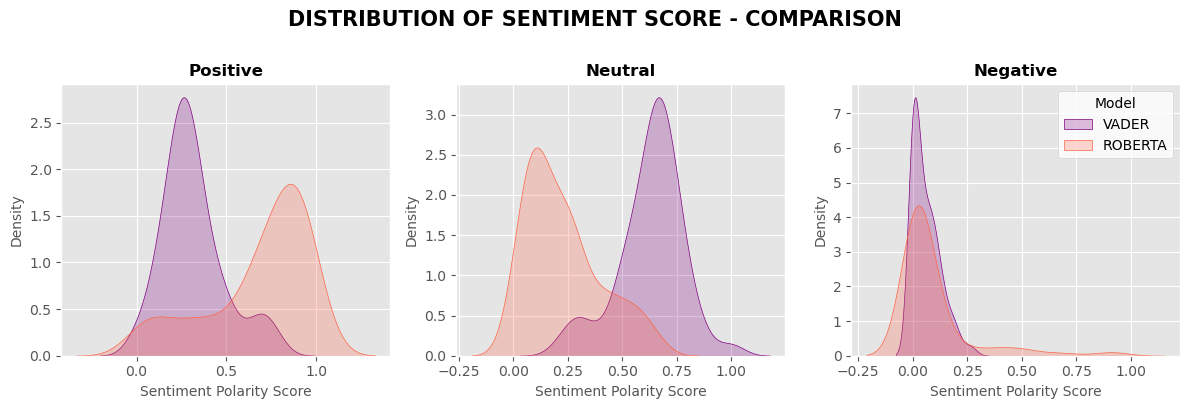

In [23]:
# Distribution of Sentiment Scores
fig, axs = plt.subplots(1, 3, figsize = (12, 4))

# POSITIVE Sentiment
sns.kdeplot(data = results_df['Vader Pos'], ax = axs[0], shade = True, color = 'purple', label = 'VADER')
sns.kdeplot(data = results_df['Roberta Pos'], ax = axs[0], shade = True, color = 'tomato', label = 'ROBERTA')
axs[0].set_title('Positive', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Sentiment Polarity Score', fontsize = 10)
axs[0].set_ylabel('Density', fontsize = 10)

# NEUTRAL Sentiment
sns.kdeplot(data = results_df['Vader Neu'], ax = axs[1], shade = True, color = 'purple', label = 'VADER')
sns.kdeplot(data = results_df['Roberta Neu'], ax = axs[1], shade = True, color = 'tomato', label = 'ROBERTA')
axs[1].set_title('Neutral', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Sentiment Polarity Score', fontsize = 10)
axs[1].set_ylabel('Density', fontsize = 10)

# NEGATIVE Sentiment
sns.kdeplot(data = results_df['Vader Neg'], ax = axs[2], shade = True, color = 'purple', label = 'VADER')
sns.kdeplot(data = results_df['Roberta Neg'], ax = axs[2], shade = True, color = 'tomato', label = 'ROBERTA')
axs[2].set_title('Negative', fontweight = 'bold', fontsize = 12)
axs[2].set_xlabel('Sentiment Polarity Score', fontsize = 10)
axs[2].set_ylabel('Density', fontsize = 10)

plt.suptitle('DISTRIBUTION OF SENTIMENT SCORE - COMPARISON', fontweight = 'bold', fontsize = 15, y = 1.01)
plt.legend(title = 'Model').get_frame().set_facecolor('white')
plt.tight_layout()
plt.show()

Let's compute the VADER and ROBERTA **accuracy** by comapring their *predicted* sentiment labels ('Vader label' and 'Roberta label') to the true *'Sentiment'* column:

In [24]:
# Calculate accuracy for VADER
vader_accuracy = (results_df['Vader Label'] == results_df['Sentiment']).mean() * 100

# Calculate accuracy for ROBERTA
roberta_accuracy = (results_df['Roberta Label'] == results_df['Sentiment']).mean() * 100

print(f'Accuracy of VADER: {vader_accuracy:.2f}%')
print(f'Accuracy of ROBERTA: {roberta_accuracy:.2f}%')

Accuracy of VADER: 86.00%
Accuracy of ROBERTA: 79.00%


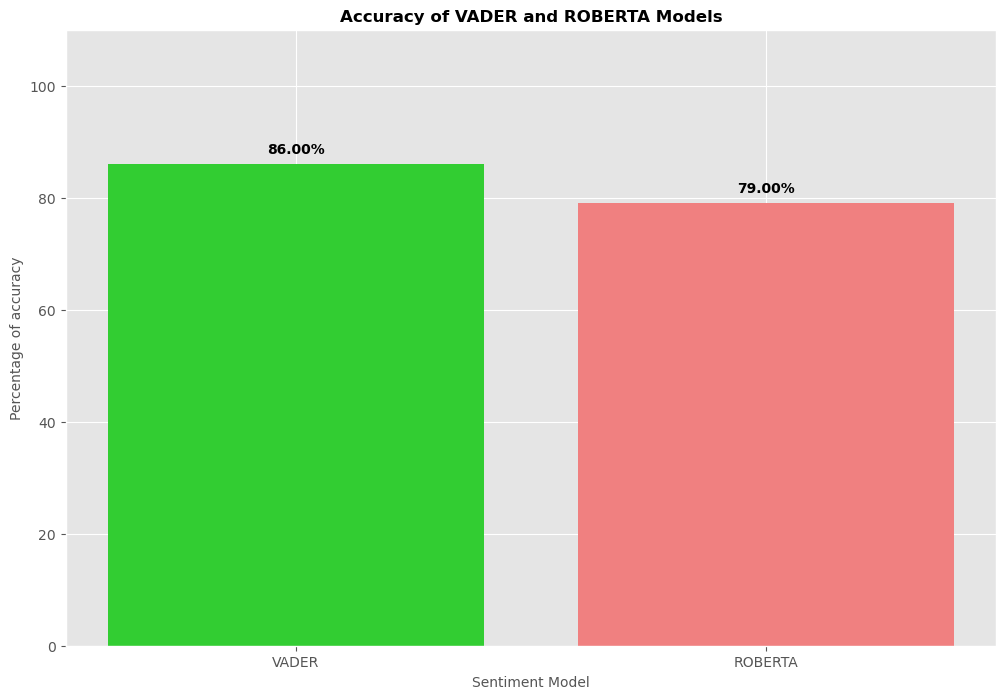

In [25]:
accuracy = [vader_accuracy, roberta_accuracy]
labels = ['VADER', 'ROBERTA']

# Accuracy Comparison
plt.figure(figsize = (12, 8))
plt.bar(labels, accuracy, color = ['limegreen', 'lightcoral'])
plt.title('Accuracy of VADER and ROBERTA Models', fontweight = 'bold', fontsize = 12)
plt.xlabel('Sentiment Model', fontsize = 10)
plt.ylabel('Percentage of accuracy', fontsize = 10)
plt.ylim(0, 110) 

# Display the percentages on the bars
for i, v in enumerate(accuracy):
    plt.text(i, v + 2, f'{v:.2f}%', ha = 'center', color = 'black', fontweight = 'bold')

plt.show()

The ***higher*** the accuracy, the ***better*** the model performs in correctly predicting sentiments.

Let's now generate the VADER and ROBERTA **classification report** to provide a comprehensive summary of the performance of the models, including information about: 

* ***Precision:*** measures the proportion of *correctly* predicted *positive* instances out of *all* instances that the model predicted as positive. It reveals how **accurate** the positive predictions are.


* ***Recall:*** measures the proportion of *correctly* predicted *positive* instances out of *all* actual *positive* instances. The **sensitivity** indicates how well the model captures all positive instances.


* ***F1-Score:*** is the harmonic *mean* of precision and recall.


* ***Support:*** is the number of actual *occurrences* of each class in the dataset. 

In [26]:
# VADER classification report
vader_classification_report = classification_report(
    results_df['Sentiment'], results_df['Vader Label'], target_names = ['Positive', 'Neutral', 'Negative']
)

# ROBERTA classification report
roberta_classification_report = classification_report(
    results_df['Sentiment'], results_df['Roberta Label'], target_names = ['Positive', 'Neutral', 'Negative']
)

print("VADER Classification Report:\n", vader_classification_report)
print("\nROBERTA Classification Report:\n", roberta_classification_report)

VADER Classification Report:
               precision    recall  f1-score   support

    Positive       0.38      1.00      0.55         3
     Neutral       0.00      0.00      0.00        10
    Negative       0.92      0.95      0.94        87

    accuracy                           0.86       100
   macro avg       0.43      0.65      0.49       100
weighted avg       0.81      0.86      0.83       100


ROBERTA Classification Report:
               precision    recall  f1-score   support

    Positive       0.19      1.00      0.32         3
     Neutral       0.29      0.20      0.24        10
    Negative       0.96      0.85      0.90        87

    accuracy                           0.79       100
   macro avg       0.48      0.68      0.48       100
weighted avg       0.87      0.79      0.82       100



Inspecting the results, we can infer that VADER model performs better on the ***negative*** class compared to the *neutral* and *positive* categories, as indicated by higher precision and F1-score values. However, the *positive* class has the lowest support, suggesting that it might be ***underrepresented*** in the dataset. 

Same for ROBERTA.

In [27]:
# Save
results_df.to_csv('rws_polarity.csv')
results_df.head(1)

,Id,Vader Neg,Vader Neu,Vader Pos,Vader Compound,Roberta Neg,Roberta Neu,Roberta Pos,Clean Title,Clean Content,Rating,Sentiment,Target,Vader Label,Roberta Label
0,0,0.087,0.606,0.308,0.9147,0.06986,0.281101,0.649038,second time buying headphones overall value money,lost first pair replaced really like fit sound...,4,Positive,2,Positive,Positive
